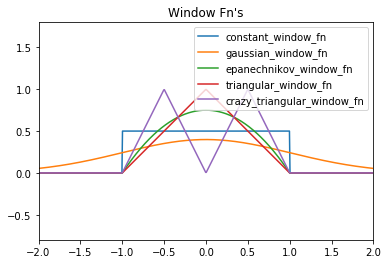

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Helper function to print windows.
def print_window_fns(*window_fn_list):
  """
  Args: 
    window_fn_list: a list of arguments each representing a 
      function object (see cell below for its signature).
  """
  X = np.linspace(-5, 5, num=1500).reshape(-1, 1)
  
  for window_fn in window_fn_list: 
    fn_values = window_fn(X)
    plt.plot(X, fn_values, label='{}'.format(window_fn.__name__))

    plt.title('Window Fn\'s')
    plt.legend()
    plt.axis('equal')
    plt.xlim((-2, 2))
    plt.ylim((-0.2, 1.2))

  plt.show()

# Various window functions / kernels

def constant_window_fn(delta):
  delta = np.absolute(delta)
  output = np.ones_like(delta) * 0.5
  output[delta > 1.0] = 0.0
  return output

def gaussian_window_fn(delta):
  output = 1 / np.sqrt(2 * np.pi) * np.exp(-delta**2 / 2.0)
  return output

def epanechnikov_window_fn(delta):
  delta = np.absolute(delta)
  output = 0.75 * (1 - delta**2)
  output[delta > 1.0] = 0.0
  return output

def triangular_window_fn(delta):
  delta = np.absolute(delta)
  output = (1 - delta)
  output[delta > 1.0] = 0.0
  return output

def crazy_triangular_window_fn(delta):
  delta = np.absolute(delta)
  output = triangular_window_fn(delta * 2 - 1)
  return output


# See how they look like
print_window_fns(constant_window_fn, 
                 gaussian_window_fn, 
                 epanechnikov_window_fn,
                 triangular_window_fn,
                 crazy_triangular_window_fn)


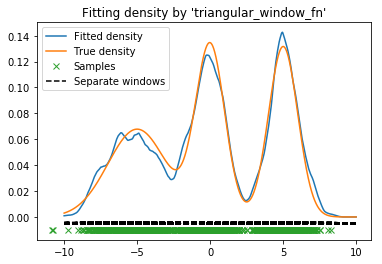

In [9]:
# Generate one sample from a mixture of Gaussians
def sample_from_gmm(num_samples, means, sigmas, weights):
  """
  Args:
    num_samples: number of samples to generate.
    means, sigmas, weights: 1-D arrays of length N representing
      the paramteres of Gaussians and the weights of mixture.
  """
  num_gaussians = len(weights) 
  assert len(means) == num_gaussians and len(sigmas) == num_gaussians
  components = np.random.choice(np.arange(num_gaussians),
                                size=num_samples,
                                p=weights)
  means_cat = means[components]
  sigmas_cat = sigmas[components]
  output = np.random.randn(num_samples) * sigmas_cat + means_cat
  
  return output

def compute_window_estimation(x, samples, window_fn, h):
  """
  Args: 
    x: ndarray of shape `(S, 1)` with `S` points at which to compute the 
      estimation, or a scalar.
    samples: ndarray of shape `(N, 1)` with samples from the unknown 
      distribution.
    window_fn: function object representing window function with signature 
      (delta -> window_value).
    h: Parzen window width parameter.

  Returns:
    output: `(S, 1)` array of estimates.
    window_fn_values: `(S, N)` size where the values of each sample's window_fn
      are computed.
  """
  x = np.asarray(x).reshape(-1, 1)  # Shape (S, 1).
  samples = samples.T  # Shape (1, N).
  
  deltas = x - samples  # Shape (S, N).
  
  window_fn_values = (1 / (samples.size * h)) * window_fn(deltas / h)
  
  return (np.sum(window_fn_values, axis=1, keepdims=True), window_fn_values)

# Compute p.d.f. of joint Gaussian
def compute_pdf_of_gmm(x, means, sigmas, weights):
  """
  Args:
    x: array of points where to evaluate the pdf.
    means, sigmas, weights: 1-D arrays of length N representing
      the paramteres of Gaussians and the weights of mixture.
  """
  x = x.reshape(-1, 1)
  means = means.reshape(1, -1)
  sigmas = sigmas.reshape(1, -1)
  weights = weights.reshape(1, -1)
  
  pdfs = (1/(sigmas * np.sqrt(2 * np.pi)) 
          * np.exp(-(x - means)**2 / (2 * sigmas**2)))
  return np.sum(pdfs * weights, axis=1)


def window_estimation(window_fn, h, n_samples, print_separate=True):
  """
    Args: 
      window_fn: function object representing window function with signature 
        (delta -> window_value).
      h: Parzen window width parameter.
  """
  gaussian_means_sigmas = np.array([
    [-5, 2],
    [0, 1],
    [5, 1]
  ])
  gaussian_weights = np.array([.34, .33, .33])

  # np.random.seed(0)
  np.random.seed()

  # ==================================================== #

  samples = sample_from_gmm(
      n_samples,
      gaussian_means_sigmas[:, 0],
      gaussian_means_sigmas[:, 1],
      gaussian_weights
  )
  samples = samples.reshape(-1, 1)

  # display predicted scores by the model as a contour plot
  X = np.linspace(-10, 10, num=2000).reshape(-1, 1)
  X_true_pdfs = compute_pdf_of_gmm(
    X, 
    gaussian_means_sigmas[:, 0],
    gaussian_means_sigmas[:, 1],
    gaussian_weights)
  
  X_fitted, window_fn_values = compute_window_estimation(X, samples, window_fn, h)

  plt.plot(X, X_fitted, label='Fitted density')
  plt.plot(X, X_true_pdfs, label='True density')
  plt.plot(samples, np.zeros_like(samples) - 0.01, 'x', label='Samples')
  plt.title('Fitting density by \'{}\''.format(window_fn.__name__))
  plt.axis('tight')  
  if print_separate:
    for sample_idx in range(window_fn_values.shape[1]):
      separate, = plt.plot(X, window_fn_values[:, sample_idx] - 0.005, '--', color='black')
  handles, labels = plt.gca().get_legend_handles_labels()
  if print_separate:
    plt.legend(handles=handles + [separate], labels=labels + ['Separate windows'])
  plt.show()

window_estimation(triangular_window_fn, h=.75, n_samples=1000)

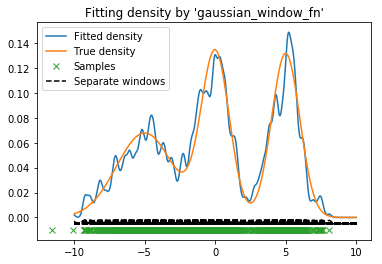

In [18]:
window_estimation(gaussian_window_fn, h=.15, n_samples=1000)

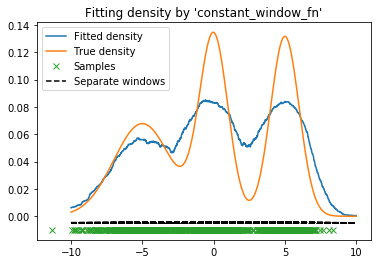

In [16]:
window_estimation(constant_window_fn, h=2, n_samples=1000)

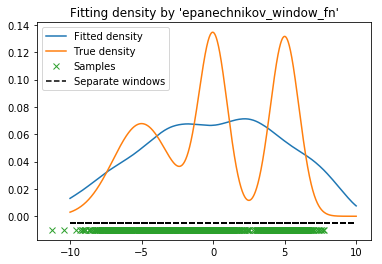

In [15]:
window_estimation(epanechnikov_window_fn, h=5, n_samples=1000)